In [1]:
import pointCollection as pc
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import h5py
%matplotlib notebook
import scipy.interpolate as si
import scipy.stats as ss
import h5py
import os
import re
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns

# change this data root to match your own
data_root = '/Volumes/ice2/ben/MAR/ATL11_with_corrections/'

In [2]:
drainage_basins=pc.grid.data().from_geotif(data_root+'/drainage_basins.tif')
gimp_mask=pc.grid.data().from_geotif(data_root+'/GimpIceMask_1km.tif')
v_mask=pc.grid.data().from_geotif(data_root+'/vel_mask_annual_sigma_lt_20.tif')
v_mask.index(np.arange(0, v_mask.shape[0], 5), np.arange(0, v_mask.shape[1], 5));
dbi=si.RegularGridInterpolator((drainage_basins.y, drainage_basins.x), drainage_basins.z, method='nearest')

bounds=None
bounds=None
bounds=None


In [3]:
def RDE(x, f=0.68, scale=0.5):
    xs=x.copy()
    xs=np.isfinite(xs)   # this changes xs from values to a boolean
    N=len(xs.nonzero()[0])
    if N<2 :
        return np.nan
    ind=np.arange(0.5, N)
    
    
    LH=np.interp(np.array([0.5-f/2, 0.5+f/2])*N, ind, np.sort(x[xs]))
    #print('LH =',LH)
    return (LH[1]-LH[0])*scale  # trying to get some kind of a width of the data ~variance


## read in the data file.  
The data were written by the 'reduce_firn_dh' notebook.  It contains one top-level group for each model, and beneath that, one group for each epoch.  Within each epoch, the data represent a 2.5-km blockmedian of the corrected elevation-change values.  This gives a smaller number of difference values for each region, and makes a file of reasonable size.

Applying the blockmedian to the drainage basin variable didn't work well (cells containing borders aren't represented well), so let's repeat the interpolation for the cell locations.

In [4]:
! ls -lt {data_root}

total 34895371
-rw-r--r-- 1 ben ben   219705964 Oct  8 23:30 combined_xover_at_differences_wrtc3_v2_SMB.h5
-rw-r--r-- 1 ben ben   193810182 Oct  8 23:07 combined_xover_at_differences_v2_SMB.h5
-rw-r--r-- 1 ben ben   126178474 Oct  1 12:52 combined_xover_at_differences_wrtc3_v2_zsurf.h5
-rw-r--r-- 1 ben ben   111349789 Oct  1 12:52 combined_xover_at_differences_v2_zsurf.h5
drwxr-xr-x 2 ben ben           8 Sep 28 20:52 temp
-rw-r--r-- 1 ben ben  8264279978 Sep 27 22:05 007_crossover_data_v1.h5
drwxr-xr-x 2 ben ben           4 Sep 27 22:02 old
-rw-r--r-- 1 ben ben   126191253 Sep 22 09:16 combined_xover_at_differences_wrtc3.h5
-rw-r--r-- 1 ben ben   111403226 Sep 21 08:39 combined_xover_at_differences_v1.h5
-rw-r--r-- 1 ben ben   112593942 Sep 14 11:42 combined_xover_at_differences_wrtc3_v1.h5
-rw-r--r-- 1 ben ben         395 Sep  2 15:12 update_corrections
-rw-r--r-- 1 ben ben         269 Sep  2 15:09 update_corrections~
-rw-r--r-- 1 ben ben 11579714767 Aug 25 10:51 relU07_dump_every_4th

In [5]:

data_file=os.path.join(data_root+'/combined_xover_at_differences_v2_SMB.h5')


strings_xover = ['2018.Q4-2019.Q2','2019.Q1-2019.Q2']
strings_at=['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']
epochs=strings_xover+strings_at

D={}
with h5py.File(data_file,'r') as h5f:
    models=list(h5f.keys())
    print(models)
for model in models:
    D[model]={}
    for epoch in epochs:
        this_group='/'.join(['',model, epoch])
        D[model][epoch]=pc.data().from_h5(data_file, group=this_group)
        D[model][epoch].assign({'basin':np.floor(dbi.__call__((D[model][epoch].y, D[model][epoch].x))*10)/10})

['GSFC_fdm_v1_1', 'MARv3_11_2_ERA_20km', 'MARv3_11_2_ERA_6km', 'MARv3_11_2_NCEP_20km']


### Calculate the percentiles for all models and for all epochs
We'll save the percentiles of the elevation differences for all the models to look at collectively

In [7]:
h_ranges=[(-10, 2000), (2000, 5000), (-10, 5000)]
h_range_cols={h_ranges[0]:0, h_ranges[1]:1}
h_range_colors={h_ranges[0]:'r', h_ranges[1]:'g'}
h_range_names=['< 2000', '> 2000']

basins=np.arange(1,9)

percentiles=np.array([5, 16, 50, 84, 95])
pct={epoch :\
     {model:\
      {h_range:\
       {rc:np.zeros((basins.size, percentiles.size)) for rc in ['raw', 'corr']}\
       for h_range in h_ranges}\
      for model in models}
     for epoch in epochs + ['melt', 'non_melt', 'all']}

for count, model in enumerate(models):
    for epoch in epochs +['melt', 'non_melt','all']:
        for h_range in h_ranges:
            pct[epoch][model][h_range]['count']=np.zeros(basins.size)

for count, model in enumerate(models): 
    for epoch in epochs:
        for basin in basins:
            for h_range in h_ranges: 
                Dsub=D[model][epoch]
                els = np.floor(Dsub.basin)==basin
                els &= (Dsub.h0 > h_range[0])
                els &= (Dsub.h0 < h_range[1])
                els &= np.isfinite(Dsub.corrected)
                Dsub=Dsub[els]
                pct[epoch][model][h_range]['raw'][basin-1,:]=ss.scoreatpercentile(Dsub.data, percentiles)
                pct[epoch][model][h_range]['corr'][basin-1,:]=ss.scoreatpercentile(Dsub.corrected, percentiles)
                pct[epoch][model][h_range]['count'][basin-1]=Dsub.size

In [8]:
# melt season runs May 15 -> August 1  (May begins 4*30 days into the new year, 2019 starts ~day 365.25)
melt_season=np.array([365.25+4*30+15, 365.25+7*30])*3600*24

for count, model in enumerate(models): 
    for basin in basins:
        for h_range in h_ranges: 
            melt_data=[]
            non_melt_data=[]
            all_data=[]
            for epoch in epochs:
                Dsub=D[model][epoch]
                els = np.floor(Dsub.basin)==basin
                els &= (Dsub.h0 > h_range[0])
                els &= (Dsub.h0 < h_range[1])
                els &= np.isfinite(Dsub.corrected)
                Dsub=Dsub[els]
                melt_days = ( ((Dsub.t0 < melt_season[0] ) & (Dsub.t1 > melt_season[0]) ) *(Dsub.t1-melt_season[0]) + \
                ((Dsub.t0 > melt_season[0] ) & (Dsub.t1 < melt_season[1]) )*(Dsub.t1-Dsub.t0) + \
                ((Dsub.t1 > melt_season[0] ) & (Dsub.t1 < melt_season[1]) ) *(melt_season[1]-Dsub.t1) )/24/3600.
                melt_data += [Dsub[melt_days>40]]
                non_melt_data += [Dsub[melt_days < 7 ]]
                all_data += [Dsub]
            temp=pc.data().from_list(melt_data)
            pct['melt'][model][h_range]['raw'][basin-1,:] = ss.scoreatpercentile(temp.data, percentiles)
            pct['melt'][model][h_range]['corr'][basin-1,:] = ss.scoreatpercentile(temp.corrected, percentiles)
            pct['melt'][model][h_range]['count'][basin-1]=temp.size
            temp=pc.data().from_list(non_melt_data)
            pct['non_melt'][model][h_range]['raw'][basin-1,:] = ss.scoreatpercentile(temp.data, percentiles)
            pct['non_melt'][model][h_range]['corr'][basin-1,:] = ss.scoreatpercentile(temp.corrected, percentiles)
            pct['non_melt'][model][h_range]['count'][basin-1]=temp.size
            temp=pc.data().from_list(all_data)
            pct['all'][model][h_range]['raw'][basin-1,:] = ss.scoreatpercentile(temp.data, percentiles)
            pct['all'][model][h_range]['corr'][basin-1,:] = ss.scoreatpercentile(temp.corrected, percentiles)
            pct['all'][model][h_range]['count'][basin-1]=temp.size

In [9]:
{basin:pct['melt'][model][h_ranges[0]]['count'][basin-1]/pct['non_melt'][model][h_ranges[0]]['count'][basin-1] for basin in basins}

{1: 0.22927418137920627,
 2: 0.2291623083589851,
 3: 0.1958616067688699,
 4: 0.06624055781522371,
 5: 0.08353808353808354,
 6: 0.17591228931435118,
 7: 0.19620811287477954,
 8: 0.2008044856167723}

### Tables of statistics:
This function reports a summary of a particular statistic for the different models.

In [10]:
models

['GSFC_fdm_v1_1',
 'MARv3_11_2_ERA_20km',
 'MARv3_11_2_ERA_6km',
 'MARv3_11_2_NCEP_20km']

In [33]:

sn={'raw':'raw',
        'GSFC_fdm_v1_1':'GSFC_v1.1',
#        'MARv3_11_ERA_zsurf':'M3.11ERA.15', 
        'MARv3_11_2_ERA_6km':'M3.11.2ERA6',
        'MARv3_11_2_ERA_20km':'M3.11.2ERA20',
       'MARv3_11_2_NCEP_20km':'M311.2NC20'
        ''}


sigma_sn={model:f'$\sigma_{{{sn[model]}}}$' for model in sn.keys()}


In [34]:
def all_basin_stats(pct, models, epoch, h_range, var):
    if var=='lt_tail':
        p1=1
        p0=0
    elif var == 'ctr':
        p1=3
        p0=1
    elif var == 'rt_tail':
        p1=4
        p0=3
   
    #short names

    sigma_sn={model:f'$\sigma_{{{sn[model]}}}$' for model in sn.keys()}
        
    column_list=['basin','raw', sigma_sn['raw']]
    for model in models:
        column_list += [sn[model]]
        column_list += [sigma_sn[model]]

    df={var:np.zeros(len(basins)) for var in column_list}
    df['basin']=np.arange(len(basins), dtype=int)+1
    
    # first two lines give  model, and resolution
    str1='basin\t raw'
    str2='\t \t'
    for model in models:
        m=re.compile('(.*)_(\d+km)').search(model)
        if m is not None:
            str1 += f'\t {m.group(1)}'
            str2 += f'\t {m.group(2)}'
        else:
            str1 += f'\t {model}'
            str2 += '\t 15km'              

    print(f'{epoch}\t{h_range[0]} m to {h_range[1]} m, {var}')
    #print(str1)
    #print(str2)
    # remaining lines give basin, range center, and range spread
    for basin in basins:
        raw=pct[epoch][models[1]][h_range]['raw'][basin-1,:]
        thestr=f'{basin}:\t {0.5*(raw[ p1]+raw[p0]):2.3f}({(raw[ p1]-raw[p0]):2.3f})'
        df['raw'][basin-1]=0.5*(raw[ p1]+raw[p0])
        df[sigma_sn['raw']][basin-1]=(raw[ p1]-raw[p0])
        for model in models:        
            corr=pct[epoch][model][h_range]['corr'][basin-1,:]
            thestr += f' \t{0.5*(corr[p1]-corr[p0]):2.3f}({(corr[p1]-corr[p0]):2.3f})'
            df[sn[model]][basin-1]=0.5*(corr[p1]-corr[p0])
            df[sigma_sn[model]][basin-1]=corr[p1]-corr[p0]                  
        #print(thestr)
    #df=pd.DataFrame(df)
    #df=df[columns]
    df=pd.DataFrame(df)[column_list]
    return df
    


In [35]:
def highlight_minabs(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = np.abs(data) == np.abs(data).min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == np.abs(data).min().min()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [36]:
def bold_abs_lt_first(data):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr_good = 'font-weight: bold' 
    attr_bad = 'color : red'
    is_lt = np.abs(data) < np.abs(data[0])
    temp = [attr_good if v else attr_bad for v in is_lt]
    temp[0] = ''
    return temp
    

## Center statistics: Central peak
Look at the width of the central peak for two epochs.  

#### All data

In [37]:
df=all_basin_stats(pct, models, 'all', h_ranges[2],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

all	-10 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.02,0.18,0.11,0.22,0.07,0.15,0.09,0.18,0.09,0.18
1,2,-0.01,0.19,0.12,0.23,0.08,0.16,0.09,0.17,0.08,0.17
2,3,-0.02,0.27,0.16,0.31,0.14,0.27,0.14,0.29,0.13,0.25
3,4,-0.04,0.32,0.19,0.38,0.21,0.41,0.31,0.62,0.25,0.50
4,5,-0.08,0.67,0.40,0.81,0.32,0.64,0.38,0.75,0.38,0.77
5,6,-0.10,0.44,0.26,0.52,0.19,0.37,0.29,0.58,0.25,0.50
6,7,-0.08,0.22,0.14,0.28,0.09,0.19,0.11,0.23,0.10,0.21
7,8,-0.04,0.26,0.14,0.28,0.10,0.19,0.11,0.22,0.12,0.23


#### All data, low elevation:

In [39]:
df=all_basin_stats(pct, models, 'all', h_ranges[0],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

all	-10 m to 2000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.02,0.21,0.13,0.25,0.10,0.20,0.12,0.23,0.12,0.24
1,2,-0.03,0.37,0.15,0.30,0.14,0.28,0.17,0.34,0.15,0.30
2,3,-0.10,0.86,0.23,0.46,0.30,0.61,0.34,0.67,0.29,0.58
3,4,-0.30,1.50,0.30,0.59,0.98,1.95,0.88,1.75,1.11,2.22
4,5,-0.16,1.24,0.44,0.89,0.37,0.74,0.46,0.92,0.45,0.90
5,6,-0.31,1.20,0.27,0.54,0.32,0.64,0.36,0.73,0.35,0.70
6,7,-0.29,0.82,0.20,0.40,0.30,0.60,0.35,0.69,0.37,0.75
7,8,-0.03,0.68,0.22,0.44,0.22,0.44,0.27,0.54,0.27,0.55


#### All data, high elevation:

In [40]:
df=all_basin_stats(pct, models, 'all', h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

all	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.02,0.13,0.09,0.17,0.05,0.10,0.06,0.11,0.06,0.12
1,2,-0.00,0.13,0.10,0.20,0.05,0.11,0.06,0.11,0.06,0.12
2,3,-0.02,0.22,0.15,0.29,0.11,0.23,0.12,0.23,0.11,0.22
3,4,-0.05,0.30,0.19,0.37,0.19,0.38,0.30,0.59,0.24,0.47
4,5,-0.10,0.53,0.39,0.78,0.28,0.55,0.34,0.69,0.34,0.69
5,6,-0.10,0.25,0.27,0.54,0.15,0.31,0.25,0.51,0.22,0.43
6,7,-0.08,0.19,0.13,0.26,0.07,0.15,0.08,0.17,0.08,0.17
7,8,-0.02,0.18,0.11,0.23,0.07,0.14,0.07,0.15,0.08,0.17


### All non-melt data:

In [41]:
df=all_basin_stats(pct, models, 'non_melt', h_ranges[2],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

non_melt	-10 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.01,0.17,0.11,0.22,0.07,0.14,0.08,0.17,0.09,0.17
1,2,0.02,0.17,0.12,0.23,0.08,0.15,0.08,0.16,0.08,0.16
2,3,0.01,0.24,0.15,0.30,0.13,0.25,0.13,0.26,0.12,0.24
3,4,-0.04,0.29,0.18,0.37,0.19,0.38,0.29,0.58,0.23,0.45
4,5,-0.06,0.65,0.40,0.80,0.31,0.62,0.37,0.73,0.37,0.74
5,6,-0.02,0.32,0.26,0.51,0.15,0.30,0.25,0.50,0.17,0.35
6,7,-0.06,0.20,0.13,0.26,0.08,0.16,0.09,0.18,0.08,0.17
7,8,-0.02,0.26,0.14,0.27,0.09,0.17,0.10,0.20,0.11,0.21


### All melt data:

In [42]:
df=all_basin_stats(pct, models, 'melt', h_ranges[2],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

melt	-10 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.08,0.17,0.11,0.22,0.09,0.18,0.11,0.22,0.11,0.22
1,2,-0.13,0.23,0.12,0.24,0.10,0.21,0.14,0.27,0.10,0.20
2,3,-0.24,0.38,0.17,0.35,0.18,0.37,0.21,0.42,0.16,0.32
3,4,-0.04,0.60,0.22,0.44,0.31,0.62,0.44,0.87,0.39,0.79
4,5,-0.34,0.65,0.38,0.76,0.49,0.99,0.47,0.94,0.58,1.15
5,6,-0.48,0.74,0.27,0.53,0.27,0.54,0.34,0.68,0.35,0.70
6,7,-0.28,0.41,0.16,0.32,0.20,0.39,0.24,0.47,0.28,0.57
7,8,-0.13,0.29,0.16,0.31,0.14,0.28,0.17,0.34,0.18,0.36


### All melt data, at low elevation:

In [43]:
df=all_basin_stats(pct, models, 'melt', h_ranges[0],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

melt	-10 m to 2000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.09,0.22,0.13,0.26,0.12,0.23,0.14,0.28,0.14,0.28
1,2,-0.24,0.44,0.16,0.31,0.16,0.31,0.22,0.44,0.16,0.32
2,3,-0.58,1.21,0.22,0.44,0.33,0.66,0.35,0.70,0.30,0.60
3,4,-0.15,1.93,0.52,1.03,1.05,2.11,0.85,1.69,1.24,2.48
4,5,-0.17,0.88,0.41,0.83,0.45,0.90,0.43,0.87,0.48,0.96
5,6,-0.78,1.48,0.32,0.63,0.43,0.87,0.44,0.89,0.50,0.99
6,7,-0.67,0.93,0.22,0.43,0.35,0.71,0.38,0.75,0.42,0.83
7,8,-0.42,0.70,0.23,0.45,0.22,0.45,0.29,0.57,0.30,0.60


### All non-melt data, at low elevation:

In [44]:
df=all_basin_stats(pct, models, 'non_melt', h_ranges[0],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

non_melt	-10 m to 2000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,0.00,0.21,0.13,0.25,0.10,0.19,0.11,0.21,0.11,0.23
1,2,0.02,0.31,0.15,0.29,0.13,0.26,0.15,0.30,0.15,0.29
2,3,-0.00,0.73,0.23,0.47,0.29,0.58,0.32,0.63,0.28,0.57
3,4,-0.31,1.45,0.26,0.53,0.97,1.94,0.89,1.78,1.10,2.21
4,5,-0.16,1.25,0.44,0.88,0.37,0.73,0.46,0.92,0.43,0.86
5,6,-0.19,1.02,0.24,0.48,0.28,0.56,0.31,0.62,0.29,0.58
6,7,-0.12,0.53,0.19,0.37,0.23,0.45,0.28,0.56,0.23,0.46
7,8,0.03,0.67,0.22,0.44,0.19,0.39,0.23,0.46,0.22,0.44


### All non-melt data, at high elevation:

In [45]:
df=all_basin_stats(pct,  models, 'non_melt', h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

non_melt	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.01,0.13,0.09,0.17,0.05,0.09,0.05,0.11,0.06,0.11
1,2,0.01,0.11,0.10,0.20,0.05,0.11,0.06,0.11,0.06,0.12
2,3,0.00,0.19,0.14,0.28,0.11,0.21,0.11,0.22,0.11,0.21
3,4,-0.04,0.27,0.18,0.36,0.18,0.35,0.28,0.56,0.21,0.43
4,5,-0.09,0.51,0.39,0.78,0.26,0.53,0.33,0.67,0.33,0.66
5,6,-0.05,0.17,0.27,0.55,0.12,0.24,0.22,0.44,0.16,0.32
6,7,-0.06,0.17,0.12,0.24,0.06,0.13,0.07,0.14,0.07,0.14
7,8,-0.02,0.18,0.11,0.21,0.06,0.13,0.07,0.14,0.08,0.16


### All melt data, at high elevation:

In [46]:
df=all_basin_stats(pct, models, 'melt', h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

melt	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.06,0.12,0.09,0.18,0.05,0.11,0.06,0.12,0.08,0.15
1,2,-0.07,0.12,0.10,0.20,0.06,0.11,0.06,0.12,0.06,0.12
2,3,-0.17,0.23,0.17,0.33,0.16,0.33,0.17,0.33,0.15,0.30
3,4,-0.07,0.53,0.20,0.41,0.29,0.59,0.42,0.84,0.38,0.76
4,5,-0.38,0.58,0.37,0.75,0.46,0.93,0.48,0.96,0.60,1.20
5,6,-0.29,0.33,0.26,0.53,0.21,0.43,0.30,0.60,0.30,0.60
6,7,-0.17,0.21,0.15,0.31,0.13,0.25,0.15,0.31,0.19,0.38
7,8,-0.05,0.15,0.13,0.26,0.09,0.18,0.09,0.19,0.10,0.21


#### Epoch 1 (Q4 of 2018 to Q2 of 2019), low elevation:

In [23]:
df=all_basin_stats(pct, epochs[0], h_ranges[0],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2018.Q4-2019.Q2	-10 m to 2000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.04,0.19,0.09,0.18,0.11,0.21,0.11,0.23
1,2,-0.06,0.25,0.10,0.20,0.13,0.26,0.12,0.25
2,3,0.07,0.49,0.19,0.38,0.27,0.54,0.22,0.44
3,4,0.76,1.14,0.16,0.31,0.37,0.73,0.48,0.96
4,5,0.44,1.05,0.34,0.68,0.34,0.67,0.47,0.95
5,6,0.26,0.71,0.23,0.47,0.23,0.46,0.21,0.43
6,7,-0.11,0.41,0.22,0.45,0.23,0.46,0.23,0.45
7,8,-0.22,0.31,0.13,0.26,0.16,0.33,0.20,0.40


#### Epoch 1 (Q4 of 2018 to Q2 of 2019), high elevation:

In [24]:
df=all_basin_stats(pct, epochs[0], h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2018.Q4-2019.Q2	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.10,0.09,0.04,0.08,0.05,0.11,0.06,0.12
1,2,-0.09,0.09,0.04,0.09,0.06,0.12,0.07,0.13
2,3,-0.10,0.17,0.08,0.16,0.12,0.25,0.16,0.32
3,4,0.16,0.48,0.14,0.28,0.26,0.51,0.22,0.43
4,5,-0.02,0.48,0.19,0.38,0.38,0.76,0.33,0.66
5,6,-0.07,0.25,0.09,0.19,0.13,0.25,0.11,0.21
6,7,-0.08,0.18,0.06,0.13,0.10,0.20,0.12,0.23
7,8,-0.11,0.14,0.06,0.12,0.08,0.17,0.07,0.15


#### Epoch 2: (Q1 of 2019 to Q2 of 2019), at low elevation:

In [25]:
df=all_basin_stats(pct, epochs[1], h_ranges[0],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2019.Q1-2019.Q2	-10 m to 2000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.02,0.15,0.07,0.14,0.08,0.16,0.08,0.16
1,2,-0.06,0.19,0.07,0.14,0.09,0.19,0.08,0.17
2,3,-0.03,0.34,0.15,0.30,0.21,0.42,0.19,0.38
3,4,0.47,0.67,0.23,0.47,0.28,0.57,0.45,0.90
4,5,-0.11,0.60,0.28,0.55,0.23,0.45,0.26,0.52
5,6,-0.04,0.38,0.19,0.38,0.16,0.32,0.15,0.30
6,7,-0.17,0.36,0.14,0.28,0.13,0.27,0.14,0.28
7,8,-0.10,0.25,0.10,0.20,0.11,0.22,0.12,0.23


#### Epoch 2: (Q1 of 2019 to Q2 of 2019), at high elevation:

In [47]:
df=all_basin_stats(pct, models,  epochs[1], h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2019.Q1-2019.Q2	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA20,$\sigma_{M3.11.2ERA20}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,-0.05,0.09,0.04,0.09,0.04,0.09,0.04,0.09,0.05,0.09
1,2,-0.05,0.09,0.05,0.09,0.05,0.09,0.05,0.09,0.04,0.09
2,3,-0.07,0.17,0.07,0.15,0.09,0.19,0.09,0.18,0.08,0.17
3,4,0.06,0.39,0.11,0.22,0.15,0.29,0.16,0.32,0.14,0.28
4,5,-0.01,0.50,0.17,0.33,0.20,0.40,0.23,0.45,0.18,0.36
5,6,-0.12,0.22,0.07,0.13,0.09,0.18,0.11,0.22,0.10,0.20
6,7,-0.10,0.18,0.06,0.12,0.07,0.13,0.06,0.12,0.06,0.13
7,8,-0.05,0.12,0.05,0.10,0.06,0.13,0.06,0.11,0.06,0.13


GSFC seems to have done the best job in reducing the model spread.  There isn't a substantial winner here among the MAR models.  The higher resolution models (MAR_v311_ERA @ 15km and Mar_v311.2 @ 10km) have smaller spreads in a few basins, but the differences are small. The corrections also don't seem to capture a large share of the variance in the data (spreads are comparable between raw and corrected data)

#### Epoch 3: (Q2 of 2019 to Q3 of 2019), at low elevation:

In [27]:
df=all_basin_stats(pct, epochs[2], h_ranges[1],'ctr')
df.style.set_precision(2).apply(highlight_minabs, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(highlight_minabs, color='orange', axis=1, subset=[sigma_sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sn[model] for model in sn.keys()])\
    .apply(bold_abs_lt_first, axis=1, subset=[sigma_sn[model] for model in sn.keys()])

2019.Q2-2019.Q3	2000 m to 5000 m, ctr


,basin,raw,$\sigma_{raw}$,GSFC_v1.1,$\sigma_{GSFC_v1.1}$,M3.11.2ERA6,$\sigma_{M3.11.2ERA6}$,M311.2NC20,$\sigma_{M311.2NC20}$
0,1,0.00,0.13,0.05,0.10,0.05,0.10,0.06,0.11
1,2,0.02,0.13,0.07,0.14,0.06,0.13,0.06,0.12
2,3,-0.14,0.28,0.12,0.24,0.19,0.38,0.20,0.40
3,4,-0.37,0.55,0.10,0.21,0.53,1.06,0.60,1.20
4,5,-0.54,0.57,0.20,0.39,0.28,0.56,0.40,0.80
5,6,-0.31,0.32,0.18,0.37,0.16,0.31,0.16,0.32
6,7,-0.21,0.21,0.09,0.18,0.17,0.34,0.19,0.39
7,8,-0.02,0.14,0.07,0.14,0.09,0.18,0.09,0.18


Here the corrections seem to both make large reductions in the spread of the signal, and seem to correct for the large drawdown signals.  The statistics are similar across the models, although the v3.11.2 models seem to have modestly better spread than the V3.11 model, and the 10km v3.11.2 is better than the coarser resolution version.


# deeper dive into individual drainage basins: basin 1

In [28]:
basin=1
h_range=h_ranges[0]
h_bins=np.arange(-2, 2.01, 0.01)
dh_hist={}
dist_data={}
for model in models:
    dh_hist[model]={ver:np.zeros((len(h_bins)-1, len(epochs))) for ver in ['raw','corr']}
    dh_hist[model].update({ver:np.zeros(len(epochs)) for ver in ['raw_med', 'corr_med']})
    dh_hist[model]['raw_data']={}
    dh_hist[model]['corr_data']={}
    for col, epoch in enumerate(epochs):
        Dsub=D[model][epoch]
        els = np.floor(Dsub.basin)==basin
        els &= (Dsub.h0 > h_range[0])
        els &= (Dsub.h0 < h_range[1])
        Dsub=Dsub[els]
        dh_hist[model]['raw_med'][col] = np.median(Dsub.data)
        dh_hist[model]['corr_med'][col] = np.median(Dsub.corrected)
        dh_hist[model]['raw'][:, col] = np.histogram(Dsub.data, bins=h_bins, density=True)[0]
        dh_hist[model]['corr'][:, col] = np.histogram(Dsub.corrected, bins=h_bins, density=True)[0]
        good=np.abs(Dsub.corrected)<2.5
        dh_hist[model]['raw_data'][epoch]=Dsub.data[good]
        dh_hist[model]['corr_data'][epoch]=Dsub.corrected[good]

This is a nicer way to compare two different models.  There's another version of violinplot that comes up on Google that puts one distribution on the left of each bar and one on the right.  Might be worth exploring.

<IPython.core.display.Javascript object>


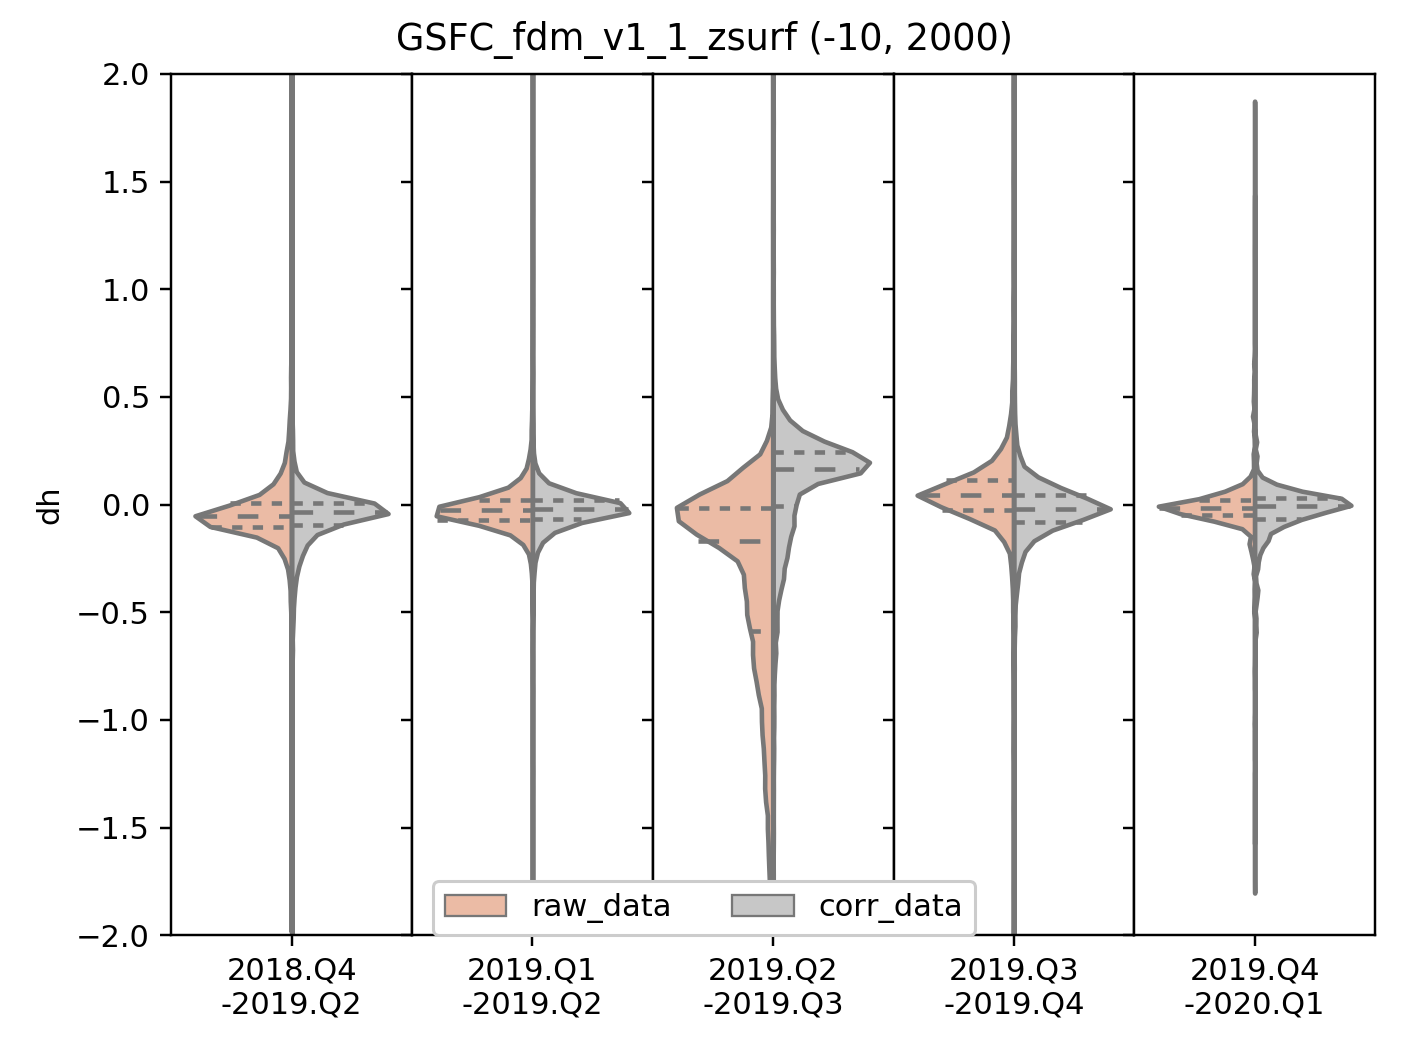

<IPython.core.display.Javascript object>


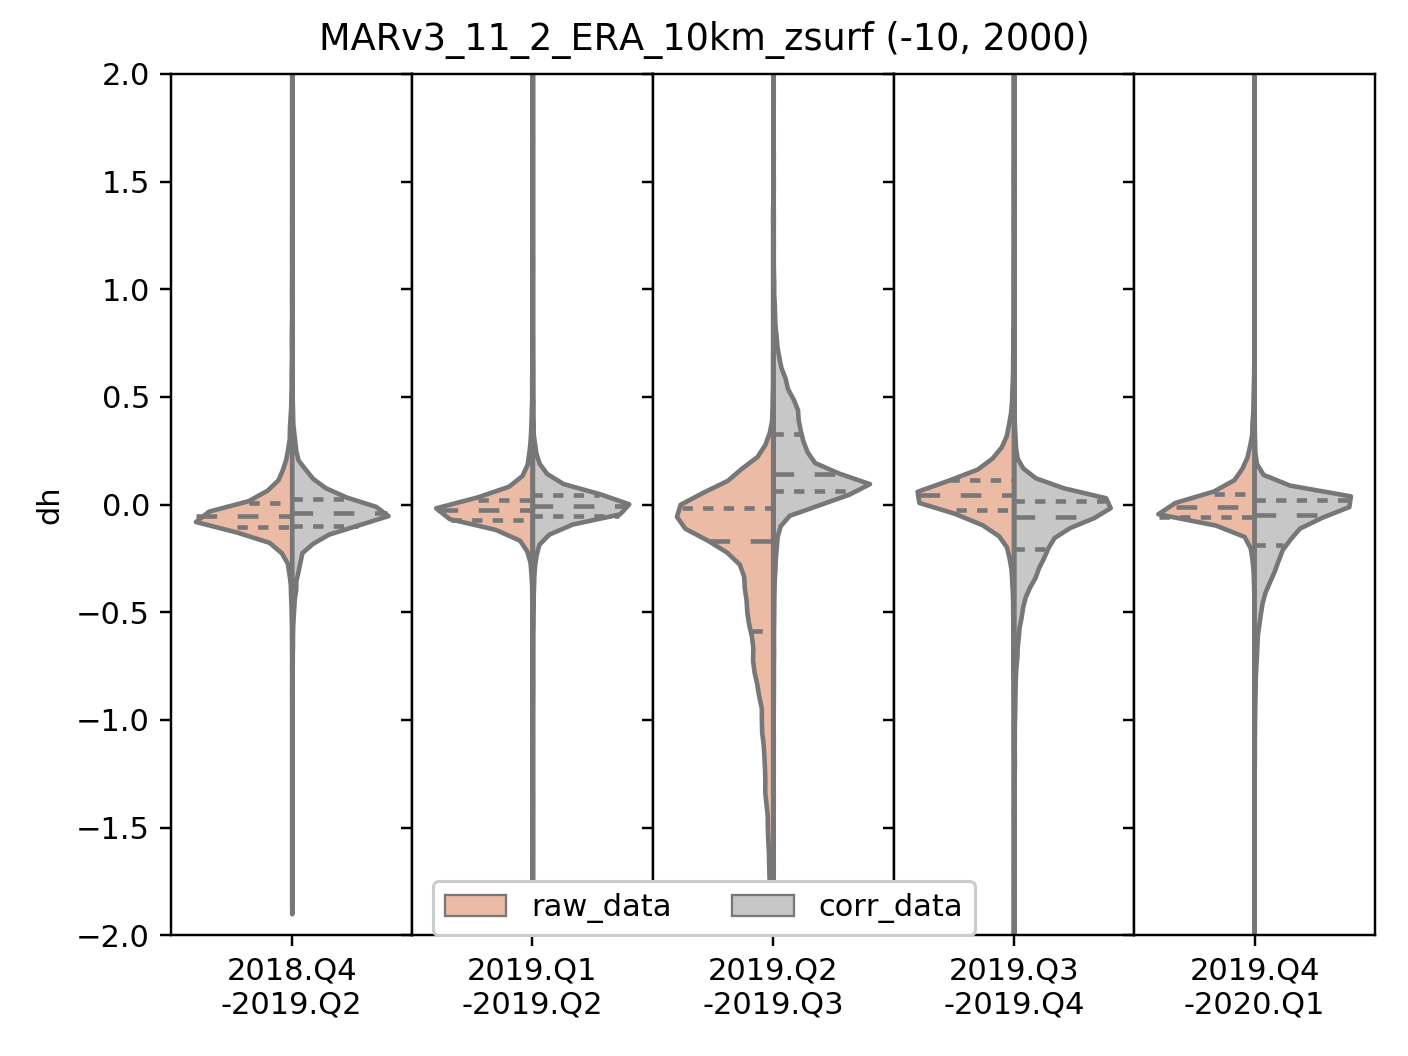

In [29]:

basin=6
for count, model in enumerate([models[0], models[1]]):

    fig, hax = plt.subplots(1, len(epochs), gridspec_kw = {'wspace':0, 'hspace':0})

    fig.suptitle(model+' '+str(h_range), fontsize=12)

    for col, epoch in enumerate(epochs):

        V = pd.DataFrame({ "raw_data" : dh_hist[model]['raw_data'][epoch],\
                          "corr_data" : dh_hist[model]['corr_data'][epoch]})
        V = V.stack().reset_index()
        V = V.drop(columns=['level_0'])
        V.columns = ['htype','dh']

        sns.violinplot(x=[epoch[:7]+'\n'+epoch[7:]]*len(V), y='dh', data=V,
                  scale='count', bw=0.05,
                  hue='htype', split=True,
                  palette='RdGy',
                  inner='quartile',
                ax=hax[col])

        hax[col].set_ylim([-2, 2])
        hax[col].legend_.remove()
        if col != 0:
            hax[col].set_ylabel('')
            hax[col].set_yticklabels([])


    handles, labels = hax[0].get_legend_handles_labels()
    fig.legend(handles, labels, 
               loc='lower center', bbox_to_anchor=(0.5, 0.1),
               ncol=2, 
               facecolor='white', framealpha=1)

    fig.tight_layout()
    fig.subplots_adjust(top=0.93)

In [ ]:
models

In [16]:
def three_sigma_edit_fit(G0, d0, n_iterations=5):
    good0=np.all(np.isfinite(G0), axis=1) & np.isfinite(d0)
    good=good0
    m=np.zeros(G0.shape[1])
    r=np.zeros(d0.shape)
    sigma=np.NaN
    good=np.ones_like(d0, dtype=bool)
    good_last=np.zeros_like(good)
    for ii in range(n_iterations+1):
        G=G0[good,:]
        if (G.shape[0]<G.shape[1]) or np.all(good_last==good):
            break
        m=np.linalg.solve(G.T.dot(G), G.T.dot(d0[good]))
        r=d0-G0.dot(m)
        sigma=RDE(r[good])
        good=good0 & (np.abs(r)<3*sigma)
    return m, r, sigma, good

<IPython.core.display.Javascript object>


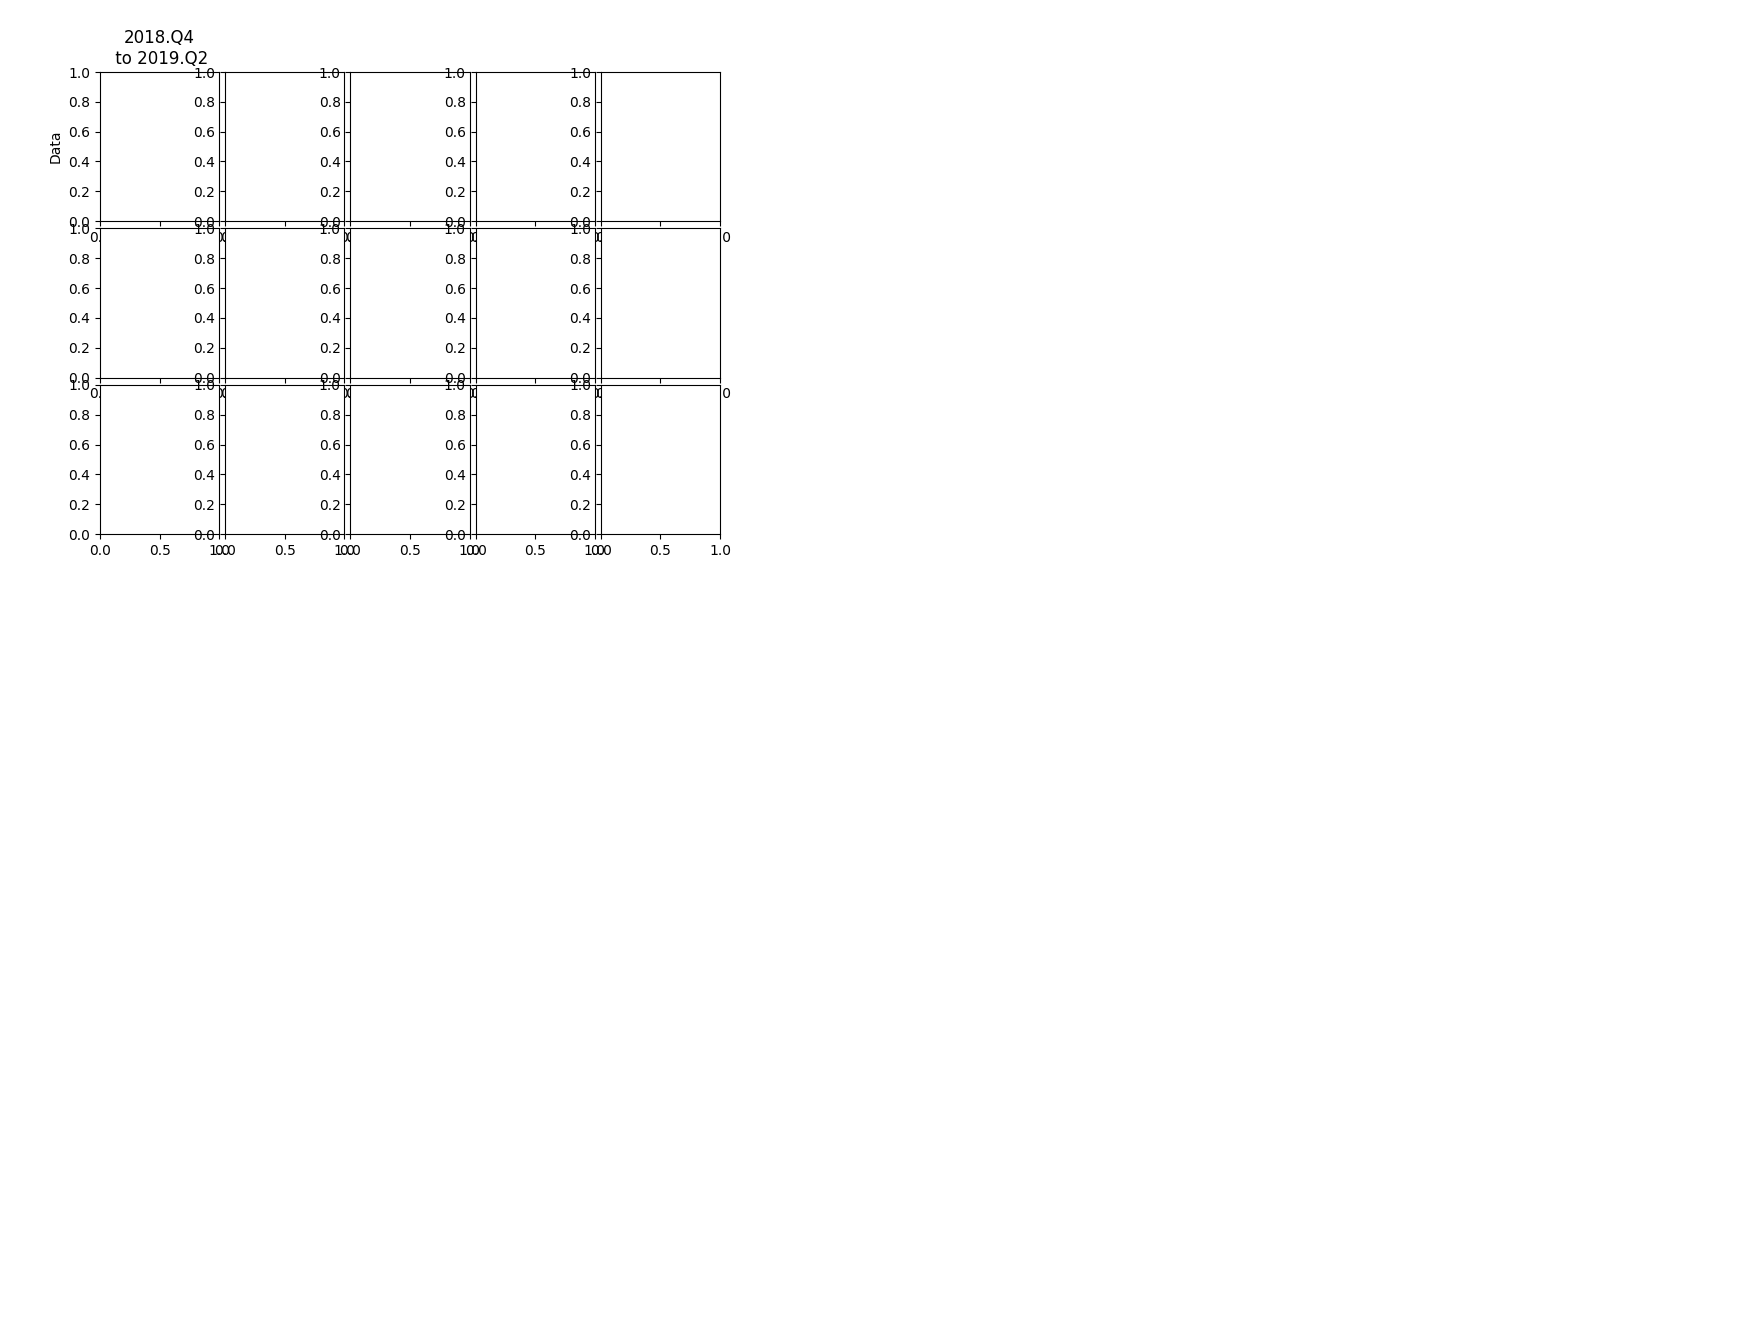

NameError: name 'DD' is not defined

In [48]:

fig=plt.figure(figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=epochs
for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km_zsurf', 'GSFC_fdm_v1_1_zsurf']):
    for col, epoch in enumerate(epochs):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model.replace('_zsurf','').replace('_6km',''))
        if model == 'Data':
            this_D=DD['MARv3_11_2_ERA_6km_zsurf']
            temp=this_D[this_D.epoch==col]
            dh=F['MARv3_11_2_ERA_6km_zsurf']['A']['r'][this_D.epoch==col]
        else:
            this_D=DD[model]
            temp=this_D[this_D.epoch==col]            
            dh=F[model]['A+ B*dh_m + C*h_star*dh_m']['r'][this_D.epoch==col]    
        ind=np.argsort(np.abs(dh))    
        hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 2, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m')


In [39]:
data_file=os.path.join(data_root+'/combined_xover_at_differences_wrtc3.h5')


epochs_c3=strings_xover+['2019.Q2-2019.Q3', '2019.Q2-2019.Q4', '2019.Q2-2020.Q1']
D_c3={}
with h5py.File(data_file,'r') as h5f:
    models=list(h5f.keys())
    print(models)
for model in models:
    D_c3[model]={}
    for epoch in epochs_c3:
        this_group='/'.join(['',model, epoch])
        D_c3[model][epoch]=pc.data().from_h5(data_file, group=this_group)
        D_c3[model][epoch].assign({'basin':np.floor(dbi.__call__((D_c3[model][epoch].y, D_c3[model][epoch].x))*10)/10})


['GSFC_fdm_v1_1_zsurf', 'MARv3_11_2_ERA_10km_zsurf', 'MARv3_11_2_ERA_6km_zsurf', 'MARv3_11_2_NCEP_20km_zsurf']


<IPython.core.display.Javascript object>


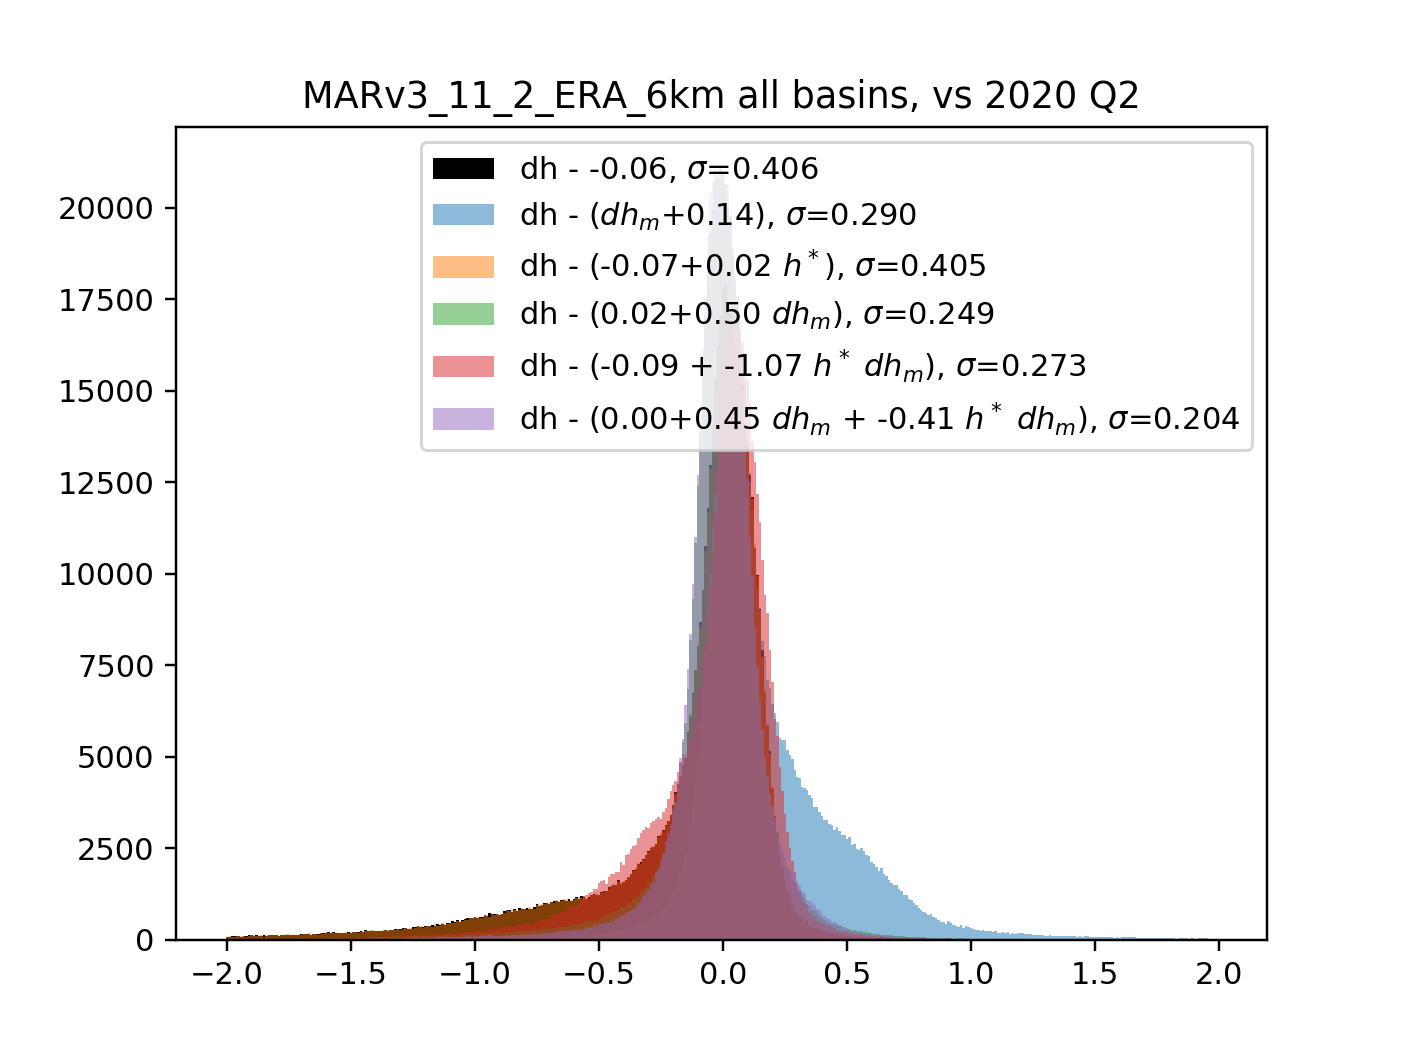

A
A+dh_m
A+B*h_star
A+B*dh_m
A+B*h_star*dh_m
A+ B*dh_m + C*h_star*dh_m


Text(0.5, 1.0, 'MARv3_11_2_ERA_6km all basins, vs 2020 Q2')

In [45]:
model='MARv3_11_2_ERA_6km_zsurf'
fits_c3, Dsub_c3 = basin_regessions(D_c3, model, np.arange(1,9), epochs_c3[0:-1], [-20, 5000])

fig=plt.figure()
ax=fig.add_subplot(111)
colors=[None]*len(fits.keys())
colors[0]='k'
fit_hists(Dsub_c3, fits_c3, fits_c3.keys(), colors)
plt.title(model.replace('_zsurf','') + ' all basins, vs 2020 Q2')

In [41]:
F_c3={}
DD_c3={}
model='GSFC_fdm_v1_1_zsurf'
F_c3[model], DD_c3[model]=basin_regessions(D_c3, model, np.arange(1, 10), epochs_c3[0:-1], [-20, 5000])

model='MARv3_11_2_ERA_6km_zsurf'
F_c3[model], DD_c3[model]=basin_regessions(D_c3, model, np.arange(1, 10), epochs_c3, [-20, 5000])



<IPython.core.display.Javascript object>


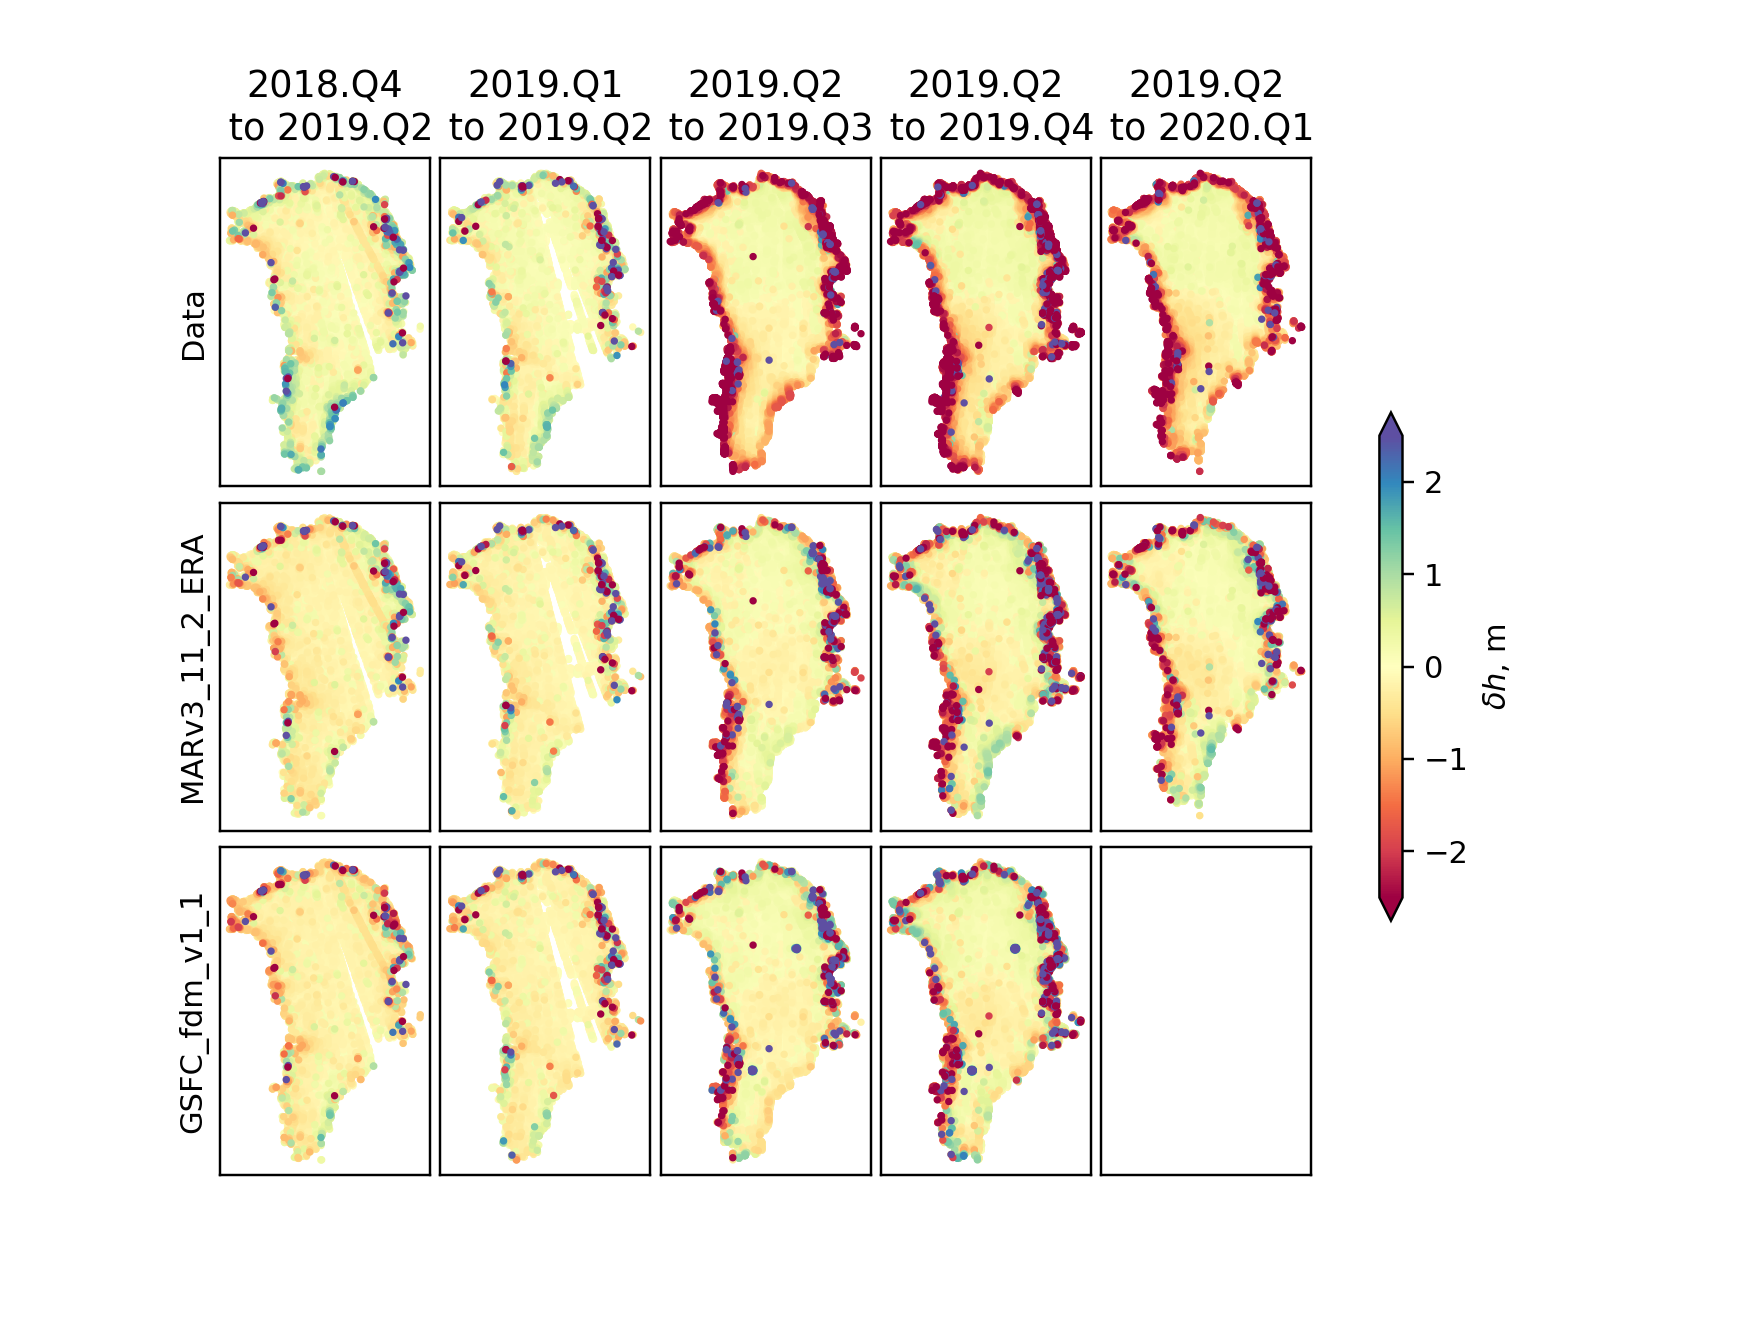

In [42]:
fig=plt.figure(figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=epochs

for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km_zsurf', 'GSFC_fdm_v1_1_zsurf']):
    for col, epoch in enumerate(epochs_c3):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model.replace('_zsurf','').replace('_6km',''))
        if model == 'Data':
            this_D=DD_c3['MARv3_11_2_ERA_6km_zsurf']
            temp=this_D[this_D.epoch==col]
            dh=F_c3['MARv3_11_2_ERA_6km_zsurf']['A']['r'][this_D.epoch==col]
        else:
            this_D=DD_c3[model]
            temp=this_D[this_D.epoch==col]            
            dh=F_c3[model]['A+ B*dh_m + C*h_star*dh_m']['r'][this_D.epoch==col]    
        if len(dh) > 0:
            ind=np.argsort(np.abs(dh))    
            hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 2, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m')


In [ ]:
dh.shape
